Tweets collected successfully
Saved collected tweets to tweets.csv
Removed duplicates: 11
Saved processed data to .csv file
------------Data Processed---------------
           display_name           handle  \
0          Mr. Raj_Modi      @abalyafuna   
1  Jitendra Kumar Yadav      @jolly_jitu   
2             Pessamela       @pessamela   
3                 Shrav     @damngoodlad   
4               Susnata  @bongtraderclub   

                                 hashtags  \
0                    [#nifty, #banknifty]   
1                    [#nifty, #nse, #bse]   
2        [#nifty, #stockmarket, #nifty50]   
3  [#nse, #nifty, #nifty50, #stockmarket]   
4           [#nifty, #sensex, #banknifty]   

                                       clean_content  likes  retweets  \
0  #Nifty Spot 26255 Above if sustain? 26333---26...      0         0   
1  CHARTS LOOKS GOOD...>>> #SwingTrading #Nifty #...      0         0   
2  On November 21, 2025, the Indian share market ...      0         0   
3  Ive

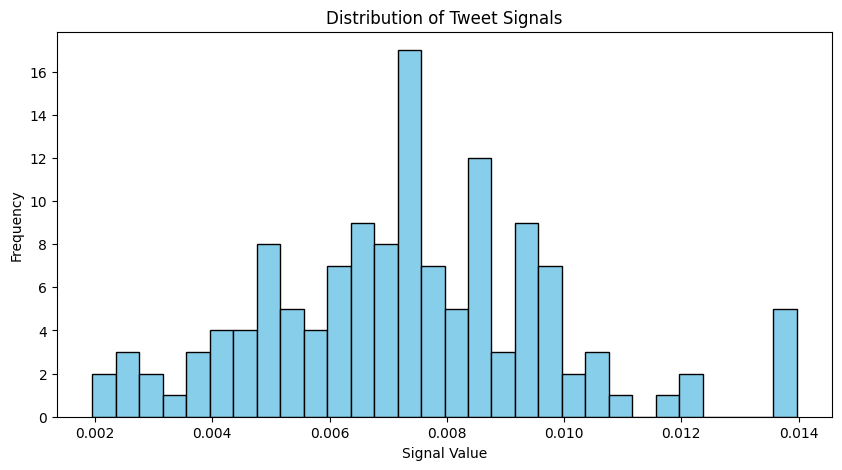

In [4]:
from src.datacollect import setup_driver, load_cookies,scrape_multiple_hashtags
from src.dataprocess import normalizeData 
from src.dataanalyzer import build_tfidf_signals,aggregate_signals,plot_signals
from src.storage import save_parquet
import pandas as pd
import json
import os
from datetime import datetime

def main():

    HASHTAGS = ["#nifty", "#nifty50", "#sensex", "#niftybank", "#banknifty","#stockmarket", "#indiastocks", "#stocks", "#trading","#intraday","#nse","#bse","#optiontrading"]

    d = setup_driver(headless=False)
    load_cookies(d)

    try:
        # ----Collections of tweets from X----------------
        collected = scrape_multiple_hashtags(d, HASHTAGS, limit_per_tag=500, scrolls=200)
        df = pd.DataFrame(collected)
        if(len(df) == 0):
            print("No tweets collected,Exiting..")
            return

        # --------Path for .csv file-------------
        fname = f"tweets_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(fname, index=False, encoding="utf-8")
        print("Saved collected tweets to tweets.csv")

        # -------------Processing the collected data------------------- 
        normalizedDf = pd.DataFrame()
        normalizedDf = normalizeData(df)
        # print("-----------------normalizedDf data----------------")
        # print(normalizedDf.head())

        # --------------building signals for tweets collected--------------------
        res = build_tfidf_signals(normalizedDf["clean_content"].astype(str).tolist(), max_features=512)
        normalizedDf["signal"] = res["doc_signal"]

        # ---------------save the processed data and signals to .csv file-------------
        fnameForProcessed = f"tweets_processed{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        normalizedDf.to_csv(fnameForProcessed, index=False, encoding="utf-8")
        print("Saved processed data to .csv file")
        
        agg = aggregate_signals(normalizedDf, doc_signal_col="signal")
        print("------------Data Processed---------------")
        print(normalizedDf.head())

        # ------------------saving the processed data to .parquet file-----------------
        save_parquet(normalizedDf, "sample_data/processed_tweets.parquet")
        
        print("--------------\n Analysis complete. Top hashtags on X:\n------------------")
        top = sorted(agg.items(), key=lambda x: x[1]["count"], reverse=True)[:10]
        for tag, v in top:
            print(f"{tag:15s} -> count={v['count']}, mean_signal={v['mean_signal']:.4f}")
    
        print("\nResults saved to sample_data/processed_tweets.parquet")

         # -----------plotting the data after processing--------------
        plot_signals(normalizedDf)
    finally:
        d.quit()
    
if __name__ == "__main__":
    main()